# Dataset verification 

The purpose of this notebook is to be able to check whether the correct data has been produced for a given dataset config file.

This notebook should run using a conda environment created from the [AML Data Prep requirements file](../../env/requirements_data_prep_azml.yml). Consult the [Env README](../../env/README.md) file for instructions.

In [1]:
import os
import pathlib
import datetime
import json
import sys

In [2]:
import pandas

In [3]:
import iris
import iris.quickplot
import cartopy
import cartopy.crs

In [ ]:
import matplotlib
import matplotlib.pyplot

In [ ]:
import xarray

In [ ]:
import azureml.core

In [ ]:
# need this python path hack to include file in parent directory, needs to be done in a cleaner way
sys.path.append(str(pathlib.Path.cwd().parent))

In [ ]:
import drivers

### Load in config and dataset


In [ ]:
configs_dir = pathlib.Path.cwd().parent / 'event_configs'
configs_dir.is_dir(), configs_dir

(True,
 PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/data_prep/event_configs'))

In [ ]:
config_path_list = [p1 for p1 in configs_dir.iterdir() if '20' in str(p1) and 'json' in str(p1)]
config_path_list

[PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/data_prep/event_configs/2020_amber_nswws_dec.json'),
 PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/data_prep/event_configs/2020_amber_nswws_oct.json'),
 PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/data_prep/event_configs/2020_storm_ciara.json'),
 PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/data_prep/event_configs/2020_storm_dennis.json'),
 PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/data_prep/event_configs/2020_storm_ellen.json'),
 PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml-pipeline/code/Users/stephen.haddad/precip_rediagnosis/data_prep/event_conf

In [ ]:
print(config_path_list[0].is_file())
with open(config_path_list[0]) as config_file:
    dataset_config = json.load(config_file)
dataset_config

True


{'event_name': '202012_nswws_amber_dec',
 'Event description': 'Two amber warnings. First for Rain issued on 17 December 2020. Valid between 09:00 on 18 December 2020 and 23:59 on 18 December 2020. Covers Wales. Second for Rain issued on 18 December 2020. Valid between 11:15 on 18 December 2020 and 23:59 on 18 December 2020. Covers England - South West England.',
 'science_info': ['https://library.metoffice.gov.uk/Portal/Default/en-GB/RecordView/Index/644537',
  'https://library.metoffice.gov.uk/Portal/Default/en-GB/RecordView/Index/644535'],
 'event_start': '2020-12-17T18:00Z',
 'event_end': '2020-12-19T00:00Z',
 'target_time_delta': 6,
 'date_fname_template': '{start.year:04d}{start.month:02d}{start.day:02d}T{start.hour:02d}{start.minute:02d}Z_{end.year:04d}{end.month:02d}{end.day:02d}T{end.hour:02d}{end.minute:02d}Z',
 'fname_extension_grid': '.nc',
 'fname_extension_tabular': '.csv',
 'merge_vars': ['latitude', 'longitude', 'time'],
 'merged_output_prefix': 'prd_merged',
 'timezone

In [ ]:
event_start_dt = datetime.datetime.strptime(dataset_config['event_start'], '%Y-%m-%dT%H:%MZ')
event_end_dt = datetime.datetime.strptime(dataset_config['event_end'], '%Y-%m-%dT%H:%MZ')
times_list = drivers.calc_dates_list(event_start_dt, event_end_dt, float(dataset_config['target_time_delta']))
final_timestamp = max(times_list)
event_start_dt, event_end_dt, final_timestamp

(datetime.datetime(2020, 12, 17, 18, 0),
 datetime.datetime(2020, 12, 19, 0, 0),
 datetime.datetime(2020, 12, 19, 0, 0, tzinfo=<UTC>))

In [ ]:
start_datestring = f'{event_start_dt.year:04d}{event_start_dt.month:02d}{event_start_dt.day:02d}T{event_start_dt.hour:02d}{event_start_dt.minute:02d}Z'
end_datestring = f'{event_end_dt.year:04d}{event_end_dt.month:02d}{event_end_dt.day:02d}T{event_end_dt.hour:02d}{event_end_dt.minute:02d}Z'
final_datestring = f'{final_timestamp.year:04d}{final_timestamp.month:02d}{final_timestamp.day:02d}T{final_timestamp.hour:02d}{final_timestamp.minute:02d}Z'



In [ ]:
prd_datastore_name = 'precip_rediagnosis_train202209'
prd_merged_file_dataset_name = 'prd_merged_all_events_files'
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [ ]:
prd_ws = azureml.core.Workspace.from_config()

In [ ]:
prd_merged_file_dataset_name

'prd_merged_all_events_files'

In [ ]:
create_dataset = False
if create_dataset:
    print('creating dataset')
    prd_datastore = azureml.core.Datastore.get(prd_ws, prd_datastore_name)
    prd_dataset_all = azureml.data.FileDataset.File.from_files((train202208_datastore, f'{prd_prefix}/*/{merged_prefix}*csv'))
else:
    print('retrieving dataset')
    prd_dataset_all = azureml.core.Dataset.get_by_name(prd_ws, name=prd_merged_file_dataset_name)
prd_dataset_all

retrieving dataset


{
  "source": [
    "('precip_rediagnosis_train202209', 'prd/*/prd_merged*csv')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "1a7d41d0-e45f-46da-a1cf-7fbfca9162f0",
    "name": "prd_merged_all_events_files",
    "version": 1,
    "description": "A file dataset containing the merged dataframe for each of the events in the current training set.",
    "workspace": "Workspace.create(name='precip_rediagnosis', subscription_id='07efdc52-cd27-48ed-9443-3aad2b6b777b', resource_group='precip_rediagnosis')"
  }
}

In [ ]:
with prd_dataset_all.mount() as mount1:
    print('\n'.join([str(p1) for p1 in pathlib.Path(mount1.mount_point).rglob('*csv') ] ))
    print(len([p1 for p1 in pathlib.Path(mount1.mount_point).rglob('*csv') ] ))


Volume mount is not enabled. 
Falling back to dataflow mount.
/tmp/tmpyxehczh4/202002_storm_ciara/prd_merged_20200207T1800Z_20200210T1800Z.csv
/tmp/tmpyxehczh4/202002_storm_dennis/prd_merged_20200214T1800Z_20200217T1800Z.csv
/tmp/tmpyxehczh4/202008_storm_ellen/prd_merged_20200819T0600Z_20200822T1200Z.csv
/tmp/tmpyxehczh4/202008_storm_francis/prd_merged_20200824T1800Z_20200826T1200Z.csv
/tmp/tmpyxehczh4/202010_nswws_amber_oct/prd_merged_20201002T0000Z_20201004T1800Z.csv
/tmp/tmpyxehczh4/202012_nswws_amber_dec/prd_merged_20201217T1800Z_20201219T0000Z.csv
/tmp/tmpyxehczh4/202102_nswws_amber_feb/prd_merged_20210219T0600Z_20210220T1800Z.csv
/tmp/tmpyxehczh4/202110_nswws_amber_oct/prd_merged_20211019T1800Z_20211021T0600Z.csv
/tmp/tmpyxehczh4/202112_storm_barra/prd_merged_20211206T1800Z_20211209T0600Z.csv
/tmp/tmpyxehczh4/2022_storm_eunice_franklin/prd_merged_20220218T1200Z_20220221T1200Z.csv
10


We then load in all the dataset from the mounted CSV files. This is quite slow!

In [ ]:
radar_regridded_fname = f'prd_radar_{start_datestring}_{final_datestring}.nc'
radar_df_fname = f'prd_radar_{start_datestring}_{final_datestring}.csv'
mogreps_g_df_fname = f'prd_mogreps_g_006H_{start_datestring}_{final_datestring}.csv'
merged_df_fname = f'prd_merged_{start_datestring}_{final_datestring}.csv'

In [ ]:
load_all = False
with prd_dataset_all.mount() as prd_all_file_mount:
    if load_all:
        print('loading all data')
        prd_path_list = [p1 for p1 in pathlib.Path(prd_all_file_mount.mount_point).rglob(f'{merged_prefix}*{csv_file_suffix}') ]
        merged_df = pandas.concat([pandas.read_csv(p1) for p1 in prd_path_list])
    else:
        selected_event_name = dataset_config['event_name']
        print(f'load data for event {selected_event_name}')
        merged_df = pandas.read_csv(pathlib.Path(prd_all_file_mount.mount_point) / dataset_config['event_name'] / merged_df_fname)
merged_df

Volume mount is not enabled. 
Falling back to dataflow mount.
load data for event 202012_nswws_amber_dec


,realization,latitude,longitude,forecast_period,forecast_reference_time,time,cloud_area_fraction,surface_altitude,air_pressure_at_sea_level,rainfall_rate,...,fraction_sum_agg,fraction_sum_instant,radar_fraction_in_band_aggregate_3hr_0.25,radar_fraction_in_band_aggregate_3hr_2.5,radar_fraction_in_band_aggregate_3hr_7.0,radar_fraction_in_band_aggregate_3hr_10.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0,49.40625,-5.484375,0 days 06:00:00,2020-12-17 12:00:00,2020-12-17 18:00:00,1.0,0.0,101173.0,0.137463,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,49.40625,-5.484375,0 days 06:00:00,2020-12-17 12:00:00,2020-12-17 18:00:00,1.0,0.0,101143.0,0.479445,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,49.40625,-5.484375,0 days 06:00:00,2020-12-17 12:00:00,2020-12-17 18:00:00,1.0,0.0,101163.0,0.234693,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,49.40625,-5.484375,0 days 06:00:00,2020-12-17 12:00:00,2020-12-17 18:00:00,1.0,0.0,101167.0,0.177696,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,49.40625,-5.484375,0 days 06:00:00,2020-12-17 12:00:00,2020-12-17 18:00:00,1.0,0.0,101219.0,0.000000,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160267,30,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.0,0.0,99713.0,0.000000,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
160268,31,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.0,0.0,99768.0,0.191107,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
160269,32,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.0,0.0,99731.0,0.261515,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
160270,33,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.0,0.0,99684.0,0.492856,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [42]:
# Currently there are issues with using azureml 
# prd_merged_azml_ds_name = 'prd_merged_all_events'
# prd_dataset_all_merged = azureml.core.Dataset.get_by_name(prd_ws, name=prd_merged_azml_ds_name)
# merged_df = prd_dataset_all_merged.to_pandas_dataframe()
# merged_df

In [ ]:
merged_df.shape

(160272, 225)

In [ ]:
[c1 for c1 in merged_df.columns if 'radar_fraction' in c1]

['radar_fraction_in_band_aggregate_3hr_0.25',
 'radar_fraction_in_band_aggregate_3hr_2.5',
 'radar_fraction_in_band_aggregate_3hr_7.0',
 'radar_fraction_in_band_aggregate_3hr_10.0',
 'radar_fraction_in_band_instant_0.25',
 'radar_fraction_in_band_instant_2.5',
 'radar_fraction_in_band_instant_7.0',
 'radar_fraction_in_band_instant_10.0']

In [ ]:
merged_df['time'].value_counts()

2020-12-17 18:00:00    26712
2020-12-18 06:00:00    26712
2020-12-18 12:00:00    26712
2020-12-18 18:00:00    26712
2020-12-19             26628
2020-12-18             26196
2020-12-18 00:00:00      516
2020-12-19 00:00:00       84
Name: time, dtype: int64

In [ ]:
(merged_df['time'].shape, sum(merged_df['time'].value_counts()))

((160272,), 160272)

In [ ]:
prd_merged_df = merged_df

In [ ]:
dataset = azureml.core.Dataset.get_by_name(prd_ws, name='prd_merged_2022_storm_eunice_franklin_tabular')
df1 = dataset.to_pandas_dataframe()
[c1 for c1 in df1.columns if 'radar_fraction' in c1]

['radar_fraction_in_band_aggregate_3hr_0.0',
 'radar_fraction_in_band_aggregate_3hr_0.25',
 'radar_fraction_in_band_aggregate_3hr_2.5',
 'radar_fraction_in_band_aggregate_3hr_7.0',
 'radar_fraction_in_band_aggregate_3hr_10.0',
 'radar_fraction_in_band_instant_0.0',
 'radar_fraction_in_band_instant_0.25',
 'radar_fraction_in_band_instant_2.5',
 'radar_fraction_in_band_instant_7.0',
 'radar_fraction_in_band_instant_10.0']

### Data verification and visualisation
Check that the radar fractions add up to 1.0

In [ ]:
agg_fraction_columns = [c1 for c1 in prd_merged_df.columns if 'agg' in c1 and 'radar_fraction' in c1]
instant_fraction_columns = [c1 for c1 in prd_merged_df.columns if 'instant' in c1 and 'radar_fraction' in c1]

In [ ]:
(prd_merged_df[[c1 for c1 in prd_merged_df.columns if 'agg' in c1 and 'radar_fraction' in c1]].sum(axis='columns') > 0.9999).value_counts()

True    160272
dtype: int64

In [ ]:
(prd_merged_df[[c1 for c1 in prd_merged_df.columns if 'instant' in c1 and 'radar_fraction' in c1]].sum(axis='columns')  > 0.9999).value_counts()

True     160254
False        18
dtype: int64

There are some bad values, so removing infeasibly high rain values.

In [ ]:
prd_merged_df = prd_merged_df[prd_merged_df['radar_max_rain_instant'] < 200]

In [ ]:
list(prd_merged_df.columns)

['realization',
 'latitude',
 'longitude',
 'forecast_period',
 'forecast_reference_time',
 'time',
 'cloud_area_fraction',
 'surface_altitude',
 'air_pressure_at_sea_level',
 'rainfall_rate',
 'convective_rainfall_rate',
 'lwe_snowfall_rate',
 'lwe_convective_snowfall_rate',
 'cloud_volume_fraction_in_atmosphere_layer_5.0',
 'cloud_volume_fraction_in_atmosphere_layer_10.0',
 'cloud_volume_fraction_in_atmosphere_layer_20.0',
 'cloud_volume_fraction_in_atmosphere_layer_30.0',
 'cloud_volume_fraction_in_atmosphere_layer_50.0',
 'cloud_volume_fraction_in_atmosphere_layer_75.0',
 'cloud_volume_fraction_in_atmosphere_layer_100.0',
 'cloud_volume_fraction_in_atmosphere_layer_150.0',
 'cloud_volume_fraction_in_atmosphere_layer_200.0',
 'cloud_volume_fraction_in_atmosphere_layer_250.0',
 'cloud_volume_fraction_in_atmosphere_layer_300.0',
 'cloud_volume_fraction_in_atmosphere_layer_400.0',
 'cloud_volume_fraction_in_atmosphere_layer_500.0',
 'cloud_volume_fraction_in_atmosphere_layer_600.0',
 '

<AxesSubplot:title={'center':'Distribution of relative humidity with height'}>

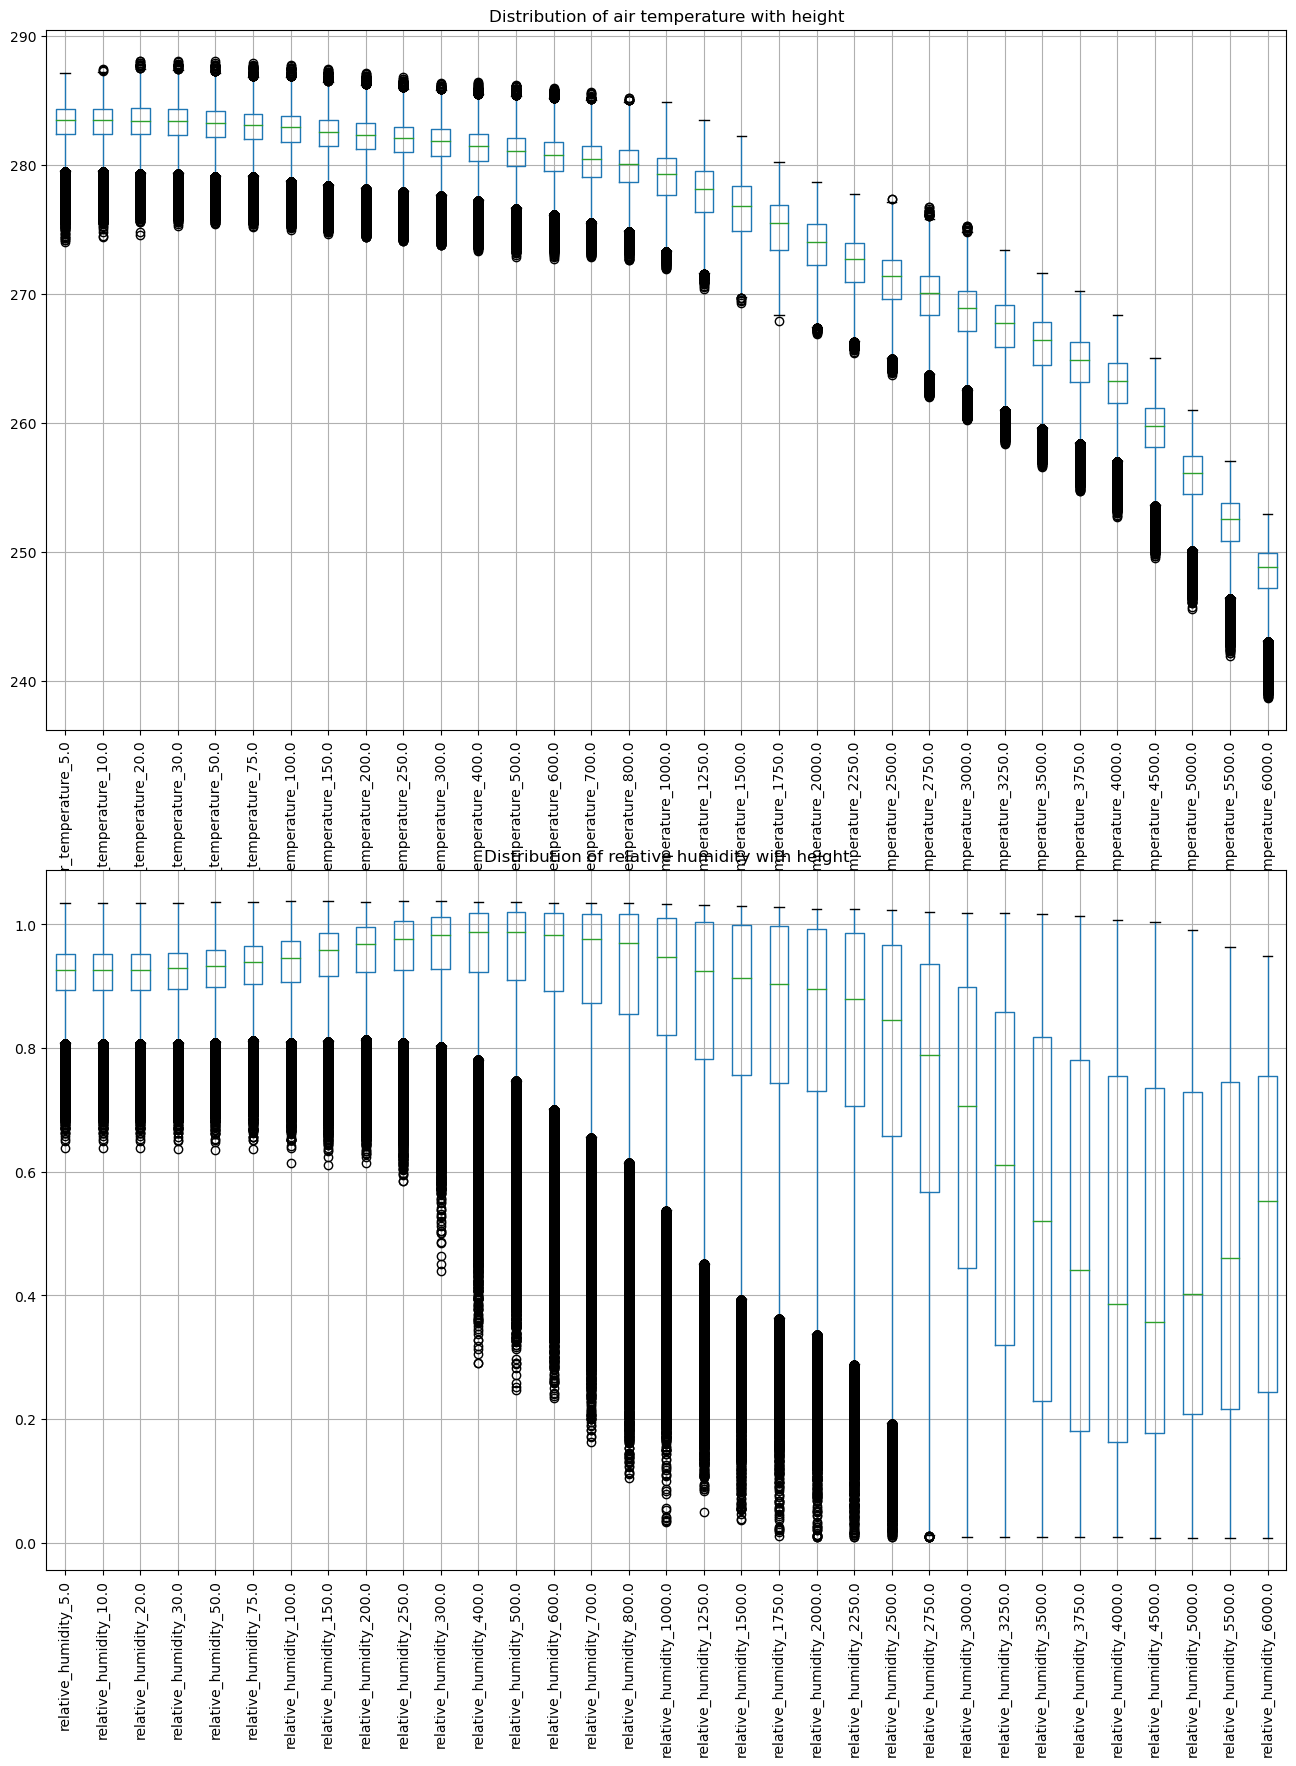

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(2,1,1,title='Distribution of air temperature with height')
prd_merged_df.boxplot(column=[c1 for c1 in prd_merged_df.columns if 'temperature' in c1], ax=ax1, rot=90)
ax2 = fig1.add_subplot(2,1,2,title='Distribution of relative humidity with height')
prd_merged_df.boxplot(column=[c1 for c1 in prd_merged_df.columns if 'relative_humidity' in c1], ax=ax2, rot=90)

In [ ]:
prd_merged_df['radar_max_rain_instant'].min(), prd_merged_df['radar_max_rain_instant'].max()

(0.0, 156.75)

In [ ]:
prd_merged_df['latitude'].min(), prd_merged_df['latitude'].max()

(49.40625, 58.78125)

In [ ]:
prd_merged_df['longitude'].min(), prd_merged_df['longitude'].max()

(-5.484375, 2.671875)

<AxesSubplot:ylabel='Frequency'>

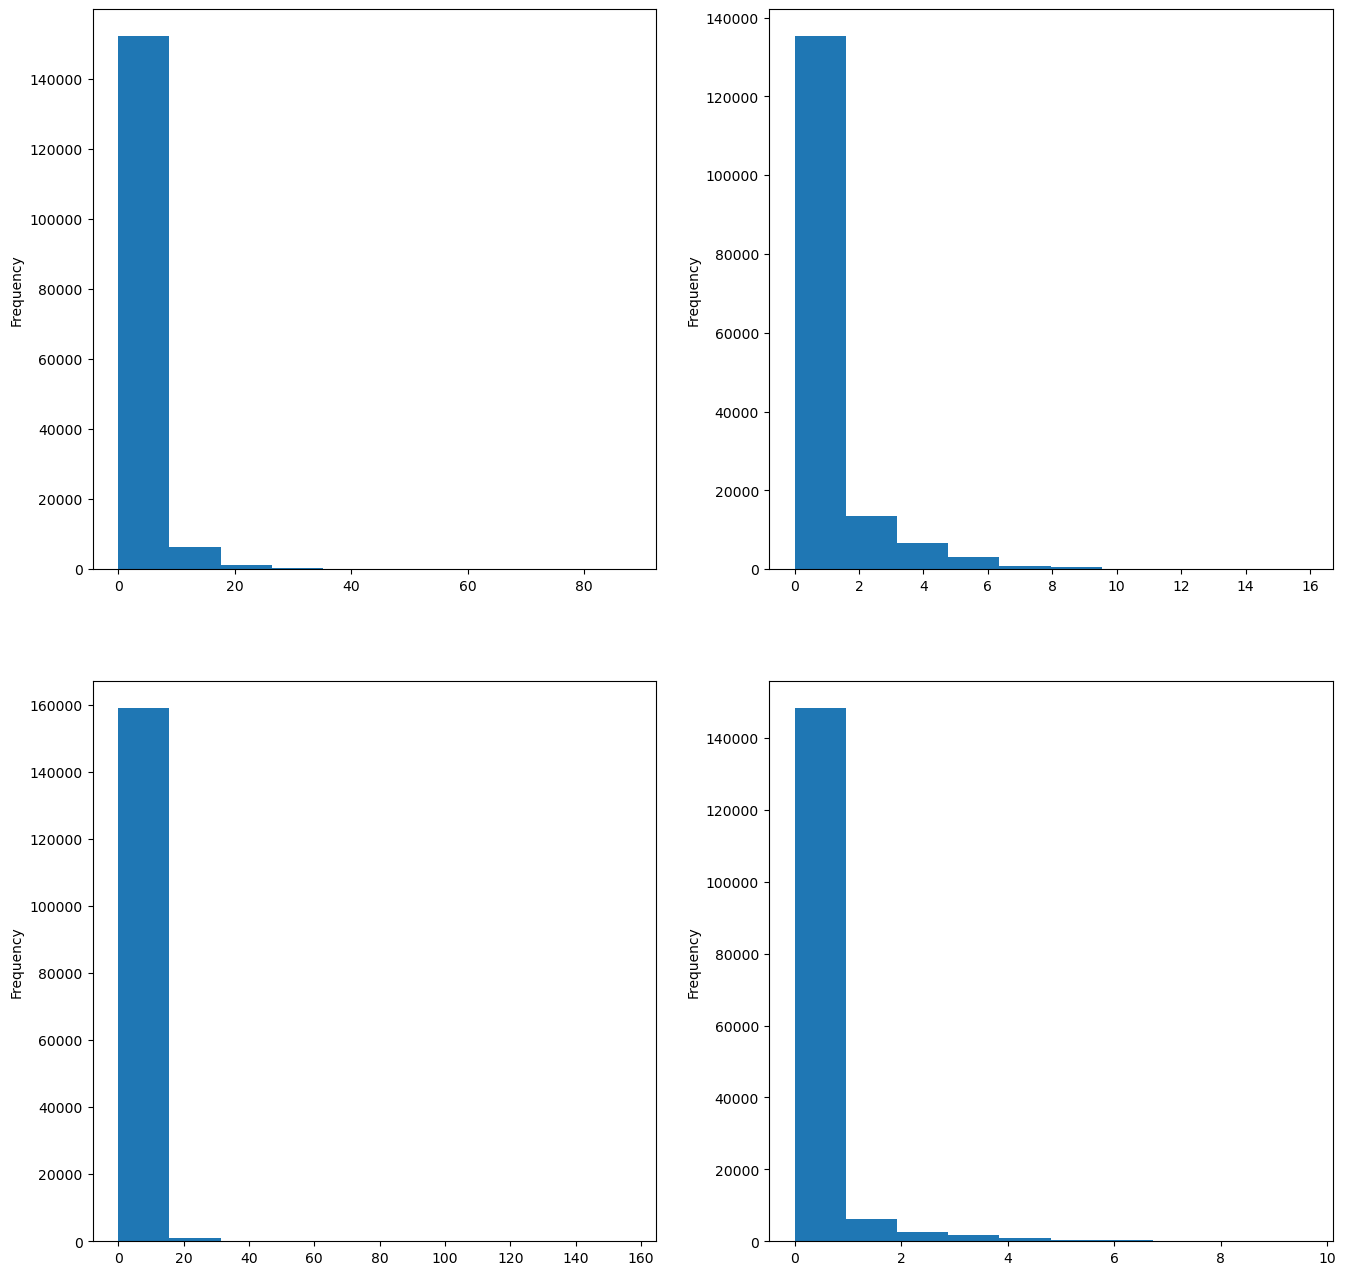

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
ax1 = fig1.add_subplot(2,2,1)
prd_merged_df['radar_max_rain_aggregate_3hr'].plot.hist(ax=ax1)
ax1 = fig1.add_subplot(2,2,2)
prd_merged_df['radar_mean_rain_aggregate_3hr'].plot.hist(ax=ax1)
ax1 = fig1.add_subplot(2,2,3)
prd_merged_df['radar_max_rain_instant'].plot.hist(ax=ax1)
ax1 = fig1.add_subplot(2,2,4)
prd_merged_df['radar_mean_rain_instant'].plot.hist(ax=ax1)


In [ ]:
[c1 for c1 in prd_merged_df.columns if 'radar_fraction' in c1 and 'instant' in c1]

['radar_fraction_in_band_instant_0.25',
 'radar_fraction_in_band_instant_2.5',
 'radar_fraction_in_band_instant_7.0',
 'radar_fraction_in_band_instant_10.0']

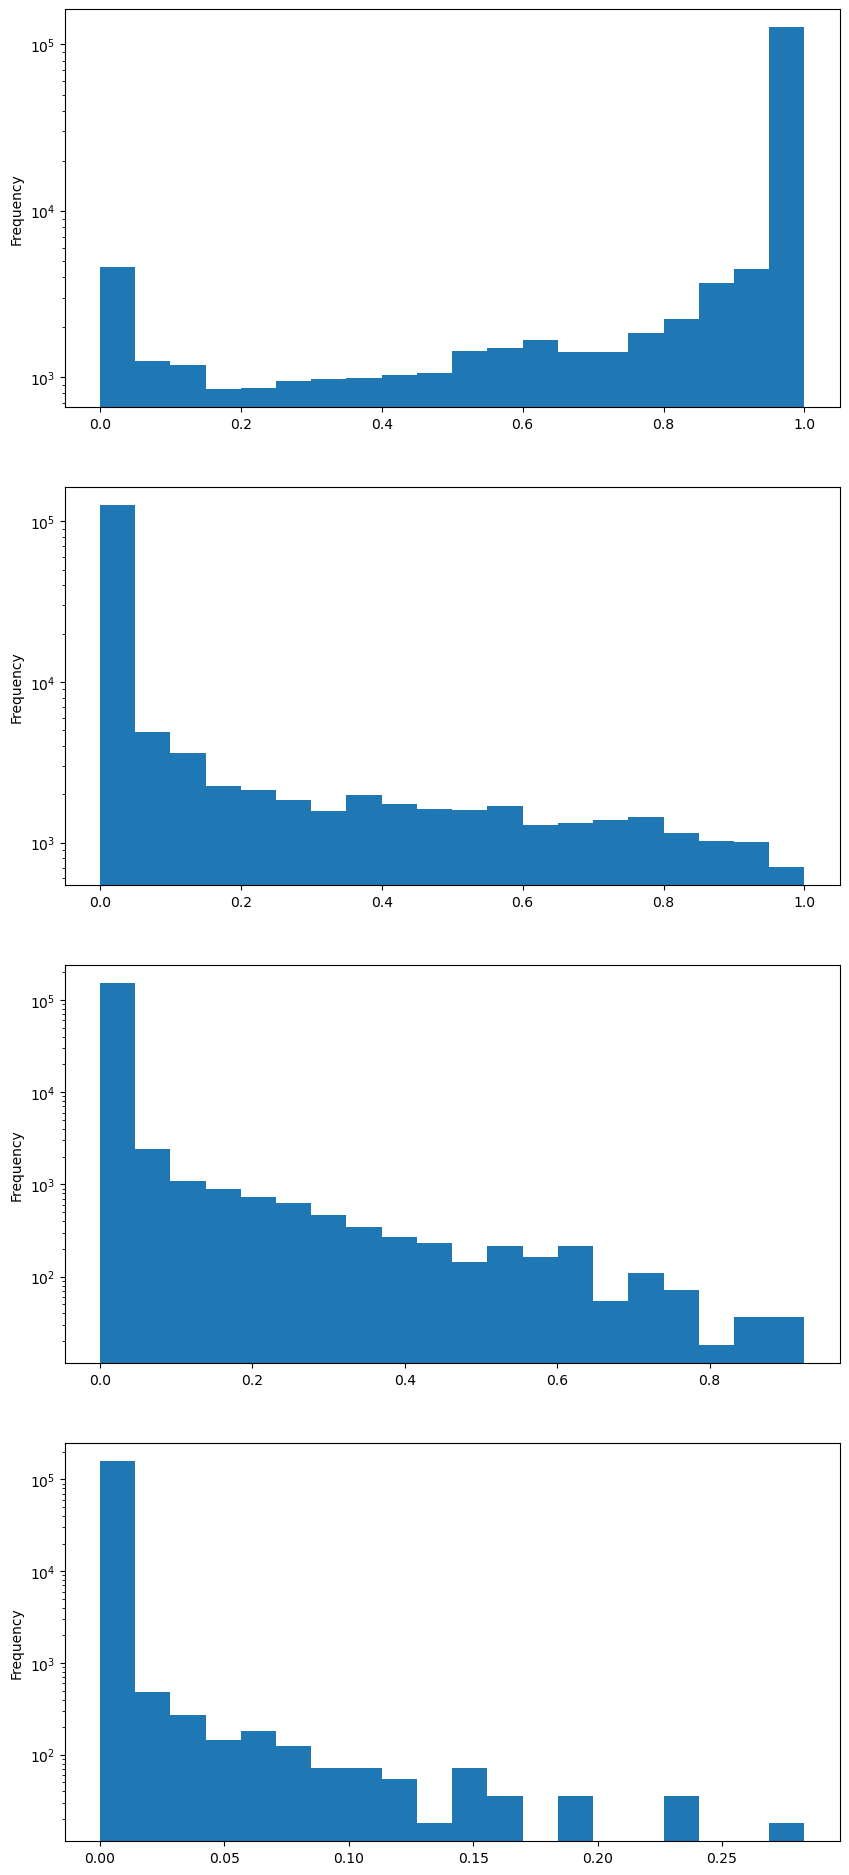

In [ ]:
fig1 = matplotlib.pyplot.figure('histogram of fraction in rainfall bands', figsize=(10,30)) 
cols_to_plot = [c1 for c1 in prd_merged_df.columns if 'band' in c1 and 'instant' in c1]
for ix1, c1 in enumerate(cols_to_plot):
    ax1 = fig1.add_subplot(5,1,ix1+1)
    _ = prd_merged_df[c1].plot.hist(bins=20,ax=ax1, log=True)

### Visualise the gridded data

In [ ]:
prd_radar_regirdded_ds_name = 'prd_radar_regridded'

In [ ]:
radar_regridded_dataset = azureml.core.Dataset.get_by_name(prd_ws, name=prd_radar_regirdded_ds_name)
radar_regridded_dataset

UserErrorException: UserErrorException:
	Message: Cannot find dataset registered with name "prd_radar_regridded" (version: None) in the workspace.
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Cannot find dataset registered with name \"prd_radar_regridded\" (version: None) in the workspace."
    }
}

In [ ]:
with radar_regridded_dataset.mount() as radar_regridded_mount:
    print('\n'.join([str(p1) for p1 in pathlib.Path(radar_regridded_mount.mount_point).rglob('*.nc') ] ))
    print(len([p1 for p1 in pathlib.Path(radar_regridded_mount.mount_point).rglob('*.nc') ] ))


In [ ]:
%%time
with radar_regridded_dataset.mount() as radar_regridded_mount:
    selected_event_name = dataset_config['event_name']
    selected_path = str(pathlib.Path(radar_regridded_mount.mount_point) / dataset_config['event_name'] / 'radar' / radar_regridded_fname)
    radar_cubelist = iris.load(selected_path)
    #force data realization as files will disappear
    _ = [c1.data for c1 in radar_cubelist]
radar_cubelist

In [ ]:
radar_cubelist.extract_cube('radar_mean_rain_aggregate_3hr')

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(10,16))
iris.quickplot.contourf(radar_cubelist.extract_cube('radar_mean_rain_aggregate_3hr')[2], ) 
# fig1.gca().coastlines()

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(10,16))
iris.quickplot.contourf(radar_cubelist.extract_cube('radar_mean_rain_instant')[2], ) 
# fig1.gca().coastlines()

In [ ]:
radar_cube_raw = iris.load_cube(str(event_data_dir / 'radar' / 'composite_rainfall_20200215.nc'))
radar_cube_raw

In [ ]:
radar_cube_raw.extract(iris.Constraint(time= lambda c1: drivers.compare_time(times_list[2], c1.point) ))

In [ ]:
radar_cube_raw.extract(iris.Constraint(time= lambda c1: drivers.compare_time(times_list[2], c1.point) )).collapsed(['projection_x_coordinate', 'projection_y_coordinate'], iris.analysis.MAX).data

In [ ]:
radar_raw_to_plot = radar_cube_raw.extract(iris.Constraint(time= lambda c1: drivers.compare_time(times_list[2], c1.point) ))
radar_raw_to_plot

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(24,24))
ax1 = fig1.add_subplot(1,1,1, projection=cartopy.crs.PlateCarree())
iris.plot.contourf(radar_raw_to_plot[300:1500,200:1450],
                   axes=ax1,
                   levels=[0.0,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.2, 1.5, 2.0, 3.0, 10.0],
                   cmap='viridis',
                  )
ax1.coastlines()

In [ ]:
prd_mg_gridded_ds_name = 'prd_mogreps_g_gridded'
mogreps_g_gridded_dataset = azureml.core.Dataset.get_by_name(prd_ws, name=prd_mg_gridded_ds_name)
mogreps_g_gridded_dataset

In [ ]:
with mogreps_g_gridded_dataset.mount() as mogreps_g_mount:
    selected_event_name = dataset_config['event_name']
    mg_fname = 'prd_mg_ts_{dt.year:04d}{dt.month:02d}{dt.day:02d}{dt.hour:02d}{dt.minute:02d}.nc'.format(dt=datetime.datetime.strptime(dataset_config['event_start'],'%Y-%m-%dT%H:%MZ'))
    selected_path = str(pathlib.Path(mogreps_g_mount.mount_point) / selected_event_name / 'mogreps-g' / mg_fname)
    print(f' loadings {selected_path}')
    mg_xrds = xarray.load_dataset(selected_path)
    fig1 = matplotlib.pyplot.figure(figsize=(20,16))
    ax1 = fig1.add_subplot(2,2,1,projection=cartopy.crs.PlateCarree())
    mg_xrds['rainfall_rate'][1,:,:].plot.contourf(ax=ax1)
    ax1.coastlines()
    ax1 = fig1.add_subplot(2,2,2,projection=cartopy.crs.PlateCarree())
    mg_xrds['convective_rainfall_rate'][1,:,:].plot.contourf(ax=ax1)
    ax1.coastlines()
    ax1 = fig1.add_subplot(2,2,3,projection=cartopy.crs.PlateCarree())
    mg_xrds['rainfall_rate'][2,:,:].plot.contourf(ax=ax1)
    ax1.coastlines()
    ax1 = fig1.add_subplot(2,2,4,projection=cartopy.crs.PlateCarree())
    mg_xrds['convective_rainfall_rate'][2,:,:].plot.contourf(ax=ax1)
    ax1.coastlines()